# Network Simulation
## Daniel Mishler
### Network simulation to consider combining networking algorithms for distance

## Todos
- Find a way to determine how much memory is occupied in each router

In [1]:
import numpy as np
import networkx as nx

import random
import dgl

import sys # for getsizeof

In [2]:
def random_adj(nvertices, nedges):
    # Returns adjacency matrix
    max_nedges = (nvertices*(nvertices-1))//2
    if nedges > max_nedges:
        print(f"error: too many edges added. maximum is {max_nedges} for {nvertices} vertices")
        return None
    
    adj = [[0 for i in range(nvertices)] for j in range(nvertices)]
    
    for e in range(nedges):
        edge_valid = False
        while edge_valid is False:
            rand = random.randint(0, nvertices*nvertices-1)
            which_row = rand // nvertices
            which_col = rand % nvertices
            if (which_row != which_col) and adj[which_row][which_col] == 0:
                edge_valid = True
        adj[which_row][which_col] = 1
        adj[which_col][which_row] = 1
    
    return adj
def matrix_to_dgl_lists(adj):
    from_list = []
    to_list = []
    i =  0
    nvertices = len(adj)
    while i < nvertices:
        j = i+1
        while j < nvertices:
            if adj[i][j] == 1:
                from_list.append(i)
                to_list.append(j)
                
                # remove this and there's probably a way to go directed here.
                to_list.append(i)
                from_list.append(j)
            j += 1
        i += 1
    
    return from_list, to_list

In [3]:
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

In [4]:
import math

In [5]:
math.sin(math.pi)

1.2246467991473532e-16

In [6]:
def adj_to_dgl(adj):
    from_list, to_list = matrix_to_dgl_lists(adj)
    g = dgl.graph((from_list, to_list))
    return g
def get_g_pos(g, layout=None):
    G = g.to_networkx()
    if layout == "circle":
        pos = nx.circular_layout(G)
    elif layout == "random":
        pos = nx.random_layout(G)
    elif layout == "planar":
        pos = nx.random_layout(G)
    elif layout == "kk":
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = None
    return pos
def draw_g(g, pos=None, layout=None):
    if pos is None:
        pos = get_g_pos(g,layout)
    
    G = g.to_networkx()
    nx.draw_networkx(G, pos)

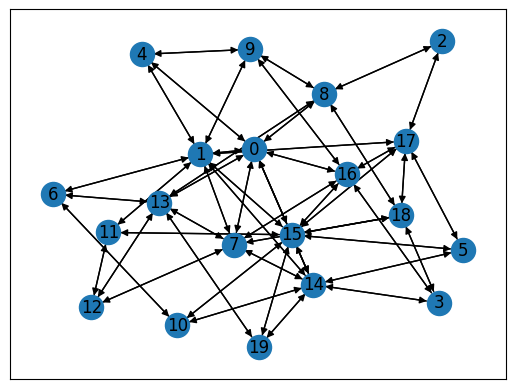

In [7]:
nvertices = 20
nedges = 50
MAX_DISTANCE = 20

adj = random_adj(nvertices,nedges)

g = adj_to_dgl(adj)
pos = get_g_pos(g, layout="kk")
draw_g(g, pos=pos)

In [ ]:
initiating_router

In [8]:
def empty_routing_dict():
    return {"distance": MAX_DISTANCE, "first_hop": -1}
def empty_routing_table():
    return [empty_routing_dict() for i in range(nvertices)]

In [9]:
class Router:
    def __init__(self, my_number, neighbors):
        self.my_number = my_number
        self.neighbors = neighbors
        self.table_queue = []
        self.routing_table = empty_routing_table()
        self.init_routing_table()
        self.all_tables = {} # for link state
        self.reconstructed_adj = None
        self.router_list = None # will be populated later
        self.table_sends = 0
        self.functions = {}
    def init_routing_table(self):
        self.routing_table = empty_routing_table()
        self.routing_table[self.my_number]["distance"] = 0
        for neighbor in self.neighbors:
            self.routing_table[neighbor]["distance"] = 1
            self.routing_table[neighbor]["first_hop"] = neighbor
    def print_adj_table(self):
        print("target | distance | first hop")
        print("-------|----------|----------")
        for i in range(nvertices):
            print(f"{i:>6} | {self.routing_table[i]["distance"]:>8} | {self.routing_table[i]["first_hop"]:>7}")
    
    
    ### Distance Vector functions
    # For local, proper version
    def update_routing_table(self, verbose=False):
        # Take the first element of the queue of tables and update self table
        in_table = self.table_queue[0]["table"]
        in_sender = self.table_queue[0]["sender"]
        response_req = self.table_queue[0]["response"]
        
        table_changed = False
        # Check to make sure my paths still exist
        for i in range(nvertices):
            if self.routing_table[i]["first_hop"] == in_sender:
                # Then the my path length needs to be exactly theirs, plus one.
                if self.routing_table[i]["distance"] < in_table[i]["distance"]+1:
                    self.routing_table[i]["distance"] = in_table[i]["distance"]+1
                    table_changed=True
        
        # Grab faster paths from the table
        for i in range(nvertices):
            if in_table[i]["distance"]+1 < self.routing_table[i]["distance"]:
                # if this new table offers a faster route
                self.routing_table[i]["distance"] = in_table[i]["distance"]+1
                self.routing_table[i]["first_hop"] = in_sender
                # then the new fastest route is sent that direction
                table_changed = True
        
        if verbose:
            print(f"router {self.my_number} processed table from {in_sender}")
        if table_changed:
            if verbose:
                print("yes, changed table. Sending out to all neighbors.")
                self.print_adj_table()
                print()
                print()
            self.send_request_to_neighbors()
        elif response_req: # We didn't change our table, but the sender wanted a response
            if verbose:
                print("no, did not change table, but sending back per request")
            self.send_request_back(in_sender)
        else:
            if verbose:
                print(f"No need for more action.")
            pass
        
        self.table_queue = self.table_queue[1:] # pop from the queue
        return table_changed
    def send_request_to_neighbors(self):
        request_dict = {}
        request_dict["table"] = self.routing_table
        request_dict["response"] = True
        request_dict["sender"] = self.my_number
        for neighbor in self.neighbors:
            self.router_list[neighbor].table_queue.append(request_dict)
            self.table_sends += 1
        return
    def send_request_back(self, target):
        request_dict = {}
        request_dict["table"] = self.routing_table
        request_dict["response"] = False
        request_dict["sender"] = self.my_number
        self.router_list[target].table_queue.append(request_dict)
        self.table_sends += 1
        return
    def clear_table_queue(self):
        table_changed = False
        while len(self.table_queue) > 0:
            table_changed = self.update_routing_table()
        return table_changed
    
    ### Link State functions
    def init_dfw(self):
        self.all_tables[self.my_number] = {}
        self.all_tables[self.my_number]['seen_by'] = [False for i in range(nvertices)]
        self.all_tables[self.my_number]['seen_by'][self.my_number] = True
        self.all_tables[self.my_number]['sent_by'] = self.my_number
        self.all_tables[self.my_number]['sender_waiting'] = True
        self.all_tables[self.my_number]['self_waiting'] = False
        self.all_tables[self.my_number]['table'] = self.routing_table
    def tables_to_forward(self):
        for key in self.all_tables:
            if self.all_tables[key]['sender_waiting'] == True:
                return True
        return False
    def send_tables_dfw(self, verbose=False):
        for key in self.all_tables:
            if self.all_tables[key]['sender_waiting'] == True:
                if self.all_tables[key]['self_waiting'] == False:
                    for neighbor in self.neighbors:
                        if self.all_tables[key]['seen_by'][neighbor] == False:
                            table_copy = {}
                            table_copy['self_waiting'] = False
                            table_copy['sender_waiting'] = True
                            table_copy['sent_by'] = self.my_number
                            table_copy['seen_by'] = self.all_tables[key]['seen_by'].copy()
                            table_copy['seen_by'][neighbor] = True # pre-marking it as seen is fine
                            table_copy['table'] = self.all_tables[key]['table']
                            self.router_list[neighbor].all_tables[key] = table_copy
                            self.table_sends += 1
                            if verbose == True:
                                print(f"router {self.my_number} sending table for router {key} DOWN to router {neighbor}")
                                print(f"    the table has been seen by: {self.all_tables[key]['seen_by']}")
                            self.all_tables[key]['self_waiting'] = True
                            break
                # if I'm still not waiting (didn't send a table down)
                if self.all_tables[key]['self_waiting'] == False:
                    # Then we should send our copy back to the sender (send up)
                    if key == self.my_number:
                        # if I am the original sender then we are done
                        pass
                    else:
                        # otherwise we should send it back to who we got it from
                        sender = self.all_tables[key]['sent_by']
                        """
                        for i in range(self.all_tables[key]['seen_by']):
                            if (self.all_tables[key]['seen_by'][i] == True):
                                self.router_list[sender].all_tables[key]['seen_by'][i] = True
                        """

                        if verbose == True:
                            print(f"router {self.my_number} sending table for router {key} UP to router {sender}")
                            print(f"    the table has been seen by: {self.all_tables[key]['seen_by']}")

                        self.router_list[sender].all_tables[key]['self_waiting'] = False
                        self.router_list[sender].all_tables[key]['sender_waiting'] = True # sending it back recursively, so the sender is certainly still waiting
                        # don't change the sent_by from the sender
                        self.router_list[sender].all_tables[key]['seen_by'] = self.all_tables[key]['seen_by'].copy()
                        # don't need to change the original table itself
                    self.all_tables[key]['sender_waiting'] = False
                    
                    
        return True
    def reconstruct_adj(self):
        self.reconstructed_adj = [[0 for i in range(nvertices)] for j in range(nvertices)]
        for key in self.all_tables:
            table = self.all_tables[key]['table']
            neighbors = [] # different from self.neighbors
            for i in range(len(table)):
                if table[i]["distance"] == 1:
                    neighbors.append(i)
            for i in neighbors:
                self.reconstructed_adj[key][i] = 1
    def dijkstra_to_table(self):
        seeking_distance = 1 # start from 1 because 0 is already done.
        while True:
            updated_table = False
            for i in range(nvertices):
                if self.routing_table[i]["distance"] > seeking_distance:
                    for j in range(nvertices):
                        if self.reconstructed_adj[i][j]:
                            if self.routing_table[j]["distance"] == seeking_distance:
                                self.routing_table[i]["distance"] = seeking_distance + 1
                                self.routing_table[i]["first_hop"] = self.routing_table[j]["first_hop"]
                                updated_table = True
                            elif self.routing_table[j]["distance"] < seeking_distance:
                                print("some kind of error occured. Abort.")
                                return
            seeking_distance += 1
            if updated_table is False:
                break # alternatively, we could stop when all entries are filled

In [10]:
def init_routers():
    routers = []
    for i in range(nvertices):
        neighbors_of_i = []
        for j in range(nvertices):
            if adj[i][j]:
                neighbors_of_i.append(j)
        routers.append(Router(i,neighbors_of_i))
    for router in routers:
        router.router_list = routers
    return routers

### Distance Vector

In [11]:
def queues_full():
    which_queues = []
    for i in range(len(routers)):
        if len(routers[i].table_queue) > 0:
            which_queues.append(i)
    return which_queues

In [12]:
def reset_table_sends():
    for router in routers:
        router.table_sends = 0

In [13]:
def distance_via_dv(initiating_router,verbose=False):
    reset_table_sends()
    routers[initiating_router].send_request_to_neighbors()
    
    while(len(queues_full()) > 0):
        which_queues = queues_full()
        run_this_one = which_queues[random.randrange(len(which_queues))]
        routers[run_this_one].update_routing_table(verbose=verbose) # could also do all updates
    
    total_sends = 0
    for router in routers:
        total_sends += router.table_sends
    return total_sends

### Link State

In [14]:
def routers_with_forwarding():
    which_routers = []
    for i in range(len(routers)):
        if routers[i].tables_to_forward():
            which_routers.append(i)
    return which_routers

In [15]:
def dfw_wrapper(verbose=False):
    # TODO: start the link state locally and the first time a router receives a singal, it init-s itself.
    reset_table_sends()
    for router in routers:
        router.init_dfw()
    
    while(len(routers_with_forwarding()) > 0):
          which_routers = routers_with_forwarding()
          run_this_one = which_routers[random.randrange(len(which_routers))]
          routers[run_this_one].send_tables_dfw(verbose)
    
    total_sends = 0
    for router in routers:
        total_sends += router.table_sends
    return total_sends

In [16]:
def distance_via_ls(verbose=False):
    send_count_ls = 0
    send_count_ls = dfw_wrapper(verbose)
    for router in routers:
        router.reconstruct_adj()
        router.dijkstra_to_table()
    return send_count_ls

### EBA-showcasing functions for routers

In [17]:
def show_my_functions(router):
    print(router.functions)

In [18]:
routers = init_routers()
routers[0].functions["show"] = show_my_functions
routers[0].functions["show"](routers[0])

{'show': <function show_my_functions at 0x7f63ff5a4b80>}


In [34]:
### Distance Vector functions
# For local, proper version
def update_routing_table(router, verbose=False):
    # Take the first element of the queue of tables and update self table
    in_table = router.table_queue[0]["table"]
    in_sender = router.table_queue[0]["sender"]
    response_req = router.table_queue[0]["response"]

    table_changed = False
    # Check to make sure my paths still exist
    for i in range(nvertices):
        if router.routing_table[i]["first_hop"] == in_sender:
            # Then the my path length needs to be exactly theirs, plus one.
            if router.routing_table[i]["distance"] < in_table[i]["distance"]+1:
                router.routing_table[i]["distance"] = in_table[i]["distance"]+1
                table_changed=True

    # Grab faster paths from the table
    for i in range(nvertices):
        if in_table[i]["distance"]+1 < router.routing_table[i]["distance"]:
            # if this new table offers a faster route
            router.routing_table[i]["distance"] = in_table[i]["distance"]+1
            router.routing_table[i]["first_hop"] = in_sender
            # then the new fastest route is sent that direction
            table_changed = True

    if verbose:
        print(f"router {router.my_number} processed table from {in_sender}")
    if table_changed:
        if verbose:
            print("yes, changed table. Sending out to all neighbors.")
            router.print_adj_table()
            print()
            print()
        router.functions["send_request_to_neighbors"](router)
    elif response_req: # We didn't change our table, but the sender wanted a response
        if verbose:
            print("no, did not change table, but sending back per request")
        router.functions["send_request_back"](router, in_sender)
    else:
        if verbose:
            print(f"No need for more action.")
        pass

    router.table_queue = router.table_queue[1:] # pop from the queue
    return table_changed
def send_request_to_neighbors(router):
    request_dict = {}
    request_dict["table"] = router.routing_table
    request_dict["response"] = True
    request_dict["sender"] = router.my_number
    for neighbor in router.neighbors:
        router.router_list[neighbor].table_queue.append(request_dict)
        router.table_sends += 1
    return
def send_request_back(router, target):
    request_dict = {}
    request_dict["table"] = router.routing_table
    request_dict["response"] = False
    request_dict["sender"] = router.my_number
    router.router_list[target].table_queue.append(request_dict)
    router.table_sends += 1
    return
def clear_table_queue(router):
    table_changed = False
    while len(router.table_queue) > 0:
        table_changed = router.functions["update_routing_table"](router)
    return table_changed
def propagate_dv_functions(src_router, verbose=True): # TODO: have the routers give copies of their own functions
    to_add = {"update_routing_table":update_routing_table,
              "send_request_to_neighbors":send_request_to_neighbors,
              "send_request_back":send_request_back,
              "clear_table_queue":clear_table_queue,
              "propagate_dv_functions":propagate_dv_functions}
    for neighbor in src_router.neighbors:
        dst_router = src_router.router_list[neighbor]
        sent = False
        for func in to_add:
            try:
                dst_router.functions[func]
            except KeyError:
                sent = True
                if verbose:
                    print(f"adding function {func} to router {neighbor} from router {src_router.my_number}")
                dst_router.functions[func] = to_add[func]
        if sent is True:
            dst_router.functions["propagate_dv_functions"](dst_router,verbose)

In [33]:
routers = init_routers()
routers[0].functions["propagate_dv_functions"] = propagate_dv_functions
routers[0].functions["propagate_dv_functions"](routers[0], verbose=False)

In [41]:
def distance_via_dv_eba(initiating_router,verbose=False):
    reset_table_sends()

    routers[initiating_router].functions["propagate_dv_functions"] = propagate_dv_functions
    routers[initiating_router].functions["propagate_dv_functions"](routers[0], verbose=verbose)    
    
    routers[initiating_router].functions["send_request_to_neighbors"](routers[initiating_router])
    
    while(len(queues_full()) > 0):
        which_queues = queues_full()
        run_this_one = which_queues[random.randrange(len(which_queues))]
        routers[run_this_one].functions["update_routing_table"](routers[run_this_one], verbose=verbose) # could also do all updates
    
    total_sends = 0
    for router in routers:
        total_sends += router.table_sends
    return total_sends

### Topology Change (Eliminating an edge or adding one)

In [19]:
def change_adj(i, j, add_or_remove=True):
    # add_or_remove: True for add, False for remove
    
    # check:
    if add_or_remove and adj[i][j]==1:
        # then do nothing
        return
    if not add_or_remove and adj[i][j]==0:
        # also do nothing
        return
    
    if add_or_remove is True:
        adj[i][j] = 1
        adj[j][i] = 1
        routers[j].neighbors.append(i)
        routers[i].neighbors.append(j)

    if add_or_remove is False:
        adj[i][j] = 0
        adj[j][i] = 0
        routers[j].neighbors.remove(i)
        routers[i].neighbors.remove(j)
    
    routers[j].init_routing_table()
    routers[i].init_routing_table()

### Comparison

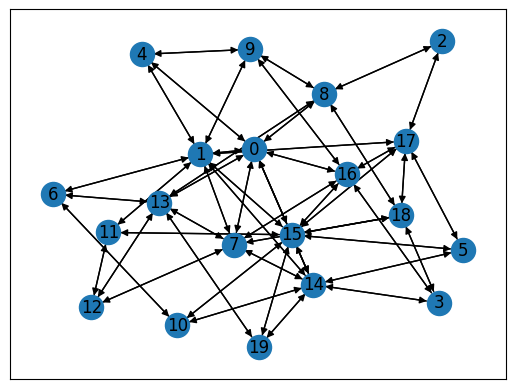

In [20]:
# draw again
draw_g(g, pos=pos)

In [21]:
routers = init_routers()
send_count_ls = distance_via_ls(verbose=False)
print(f"total sent tables: {send_count_ls}")

total sent tables: 380


In [22]:
routers[0].print_adj_table()

target | distance | first hop
-------|----------|----------
     0 |        0 |      -1
     1 |        1 |       1
     2 |        2 |       8
     3 |        2 |      16
     4 |        1 |       4
     5 |        2 |      15
     6 |        2 |      13
     7 |        1 |       7
     8 |        1 |       8
     9 |        2 |      16
    10 |        2 |      15
    11 |        2 |      15
    12 |        2 |      13
    13 |        1 |      13
    14 |        1 |      14
    15 |        1 |      15
    16 |        1 |      16
    17 |        2 |      16
    18 |        2 |      15
    19 |        2 |      15


In [43]:
routers = init_routers()
send_count_dv_init = distance_via_dv_eba(0)
print(f"total sent tables: {send_count_dv_init}")

total sent tables: 958


In [24]:
routers[0].print_adj_table()

target | distance | first hop
-------|----------|----------
     0 |        0 |      -1
     1 |        1 |       1
     2 |        2 |       8
     3 |        2 |      16
     4 |        1 |       4
     5 |        2 |      14
     6 |        2 |       1
     7 |        1 |       7
     8 |        1 |       8
     9 |        2 |      16
    10 |        2 |      14
    11 |        2 |       1
    12 |        2 |       7
    13 |        1 |      13
    14 |        1 |      14
    15 |        1 |      15
    16 |        1 |      16
    17 |        2 |      16
    18 |        2 |       7
    19 |        2 |      14


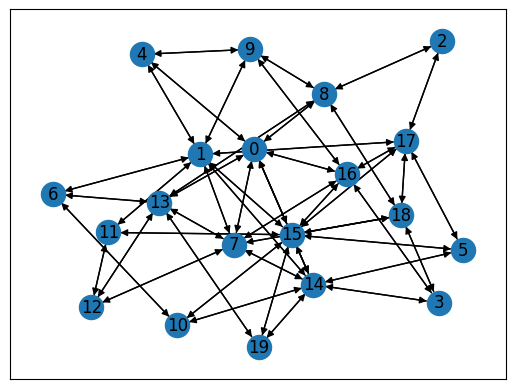

In [25]:
change_adj(0,1,False)
g = adj_to_dgl(adj)
draw_g(g, pos=pos)

In [26]:
send_count_dv_adjust = distance_via_dv_eba(0,verbose=False)
print(f"total sent tables: {send_count_dv_adjust}")

total sent tables: 168


In [27]:
routers[0].print_adj_table()

target | distance | first hop
-------|----------|----------
     0 |        0 |      -1
     1 |        2 |       7
     2 |        2 |       8
     3 |        2 |      14
     4 |        1 |       4
     5 |        2 |      14
     6 |        2 |      13
     7 |        1 |       7
     8 |        1 |       8
     9 |        2 |       8
    10 |        2 |      14
    11 |        2 |      15
    12 |        2 |       7
    13 |        1 |      13
    14 |        1 |      14
    15 |        1 |      15
    16 |        1 |      16
    17 |        2 |      15
    18 |        2 |       7
    19 |        2 |      14


In [28]:
print(f"link state             send count: {send_count_ls}")
print(f"distance vector        send count: {send_count_dv_init}")
print(f"distance vector second send count: {send_count_dv_adjust}")
print()
print()
print(f"memory footprint: {nvertices} tables per router")

link state             send count: 380
distance vector        send count: 951
distance vector second send count: 168


memory footprint: 20 tables per router
